In [1]:
import pickle
import numpy as np
import scanpy as sc

from distance_result import DistanceResult
from utils import scanpy_setup
from utils import sample_and_merge_control_random, remove_groups, subsample, generate_sparsity
from utils import inplace_check

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

[rank: 0] Global seed set to 0


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pertpy as pt

In [14]:
dss_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj'

Load in a non-simulated dataset containing a relatively large variety of conditions within a single cell line.

In [5]:
adata = pt.data.srivatsan_2020_sciplex3()

We'll set up the dataset as we usually would with `scanpy`, and select a dataset-specific standardization of the `'perturbation'` column label + calculate leiden clusters so that we have 5 groups in the control condition.

In [6]:
# sciplex3 is huge so we subset to the smallest cell type, which only contains the 24hr dose
adata = adata[adata.obs.cell_line == 'K562']
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.filter_cells(adata, min_genes=200)

In [8]:
# separate out the perturbations by dose
adata.obs['perturbation_name'] = adata.obs.perturbation.values
adata.obs['perturbation'] = adata.obs['perturbation_name'].astype(str) + '_' + adata.obs.dose_value.astype(str)
adata.obs['perturbation'] = adata.obs['perturbation'].replace({'control_0.0':'control'})

In [7]:
%%time
scanpy_setup(adata)

CPU times: user 1min 56s, sys: 2min 27s, total: 4min 24s
Wall time: 52.5 s


In summary, our adata now looks like this.

In [10]:
adata

AnnData object with n_obs × n_vars = 173149 × 20192
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_genes', 'perturbation_name', 'leiden'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [31]:
controls = ['control0', 'control1', 'control2', 'control3', 'control4']
metrics = ['euclidean', 'pearson_distance', 'mean_absolute_error', 'r2_distance', 'spearman_distance']
metrics += ['mmd', 'kl_divergence', 't_test', 'wasserstein']  # the experimental ones

In [12]:
results = {}

In [15]:
%%time
with open(f'{dss_path}/metric_runs_sciplex.pkl', 'rb') as file:
    results = pickle.load(file)
print(results.keys())

dict_keys(['100-pca-n_cells', '0.284-lognorm-count_mean', '0.264-lognorm-count_mean', '0.243-lognorm-count_mean', '0.222-lognorm-count_mean', '0.201-lognorm-count_mean', '0.179-lognorm-count_mean', '0.157-lognorm-count_mean', '0.134-lognorm-count_mean', '0.111-lognorm-count_mean'])
CPU times: user 739 ms, sys: 24.7 s, total: 25.5 s
Wall time: 25.9 s


Set the adata we'll use for the remaining runs:

In [16]:
n_min_cells = 270
merged = sample_and_merge_control_random(adata, 'control', n=5)
filtered = remove_groups(merged, min_cells=n_min_cells)

In [17]:
print("number of perturbations remaining:", len(filtered.obs.perturbation.unique()))

number of perturbations remaining: 131


### sanity checks

Similar to what we did for simulated data, plot what these real perturbations look like.

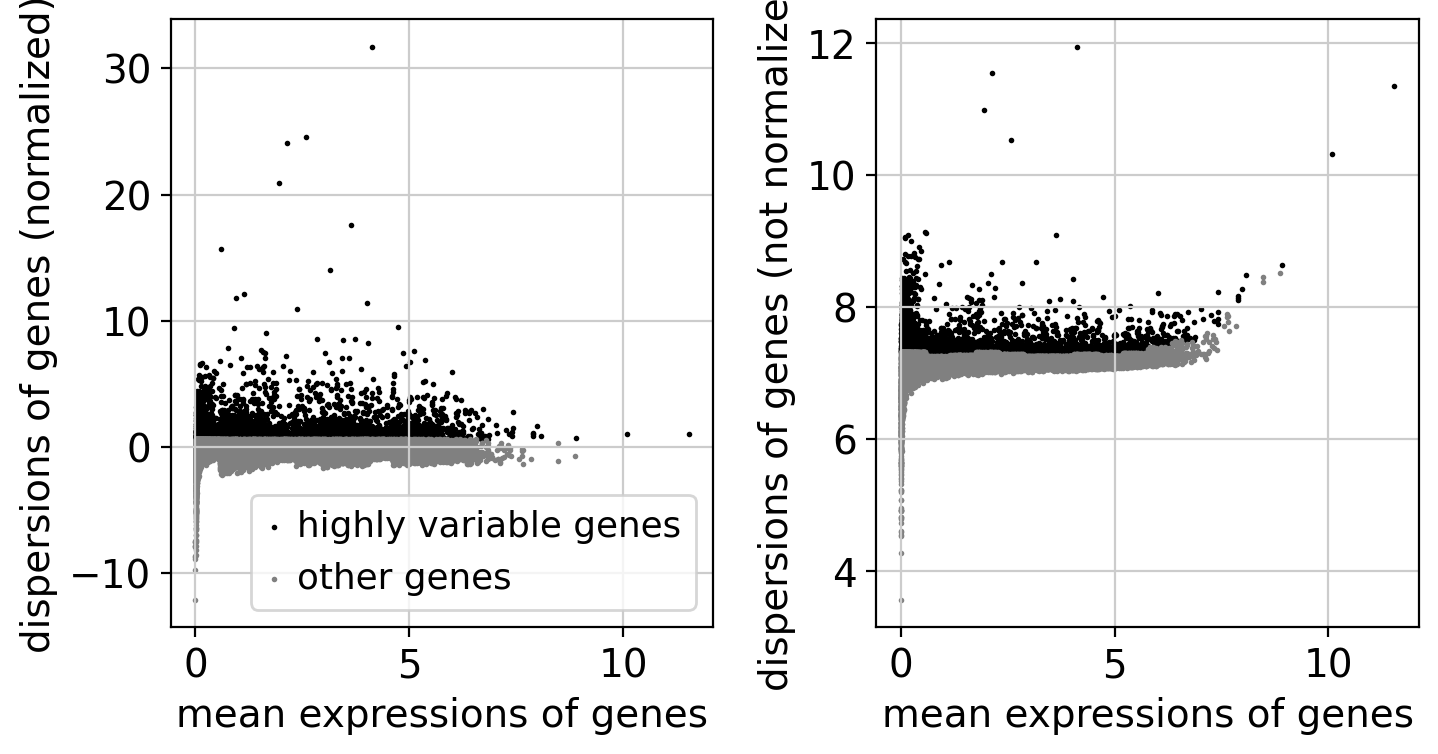

In [25]:
sc.pl.highly_variable_genes(adata)

In [22]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

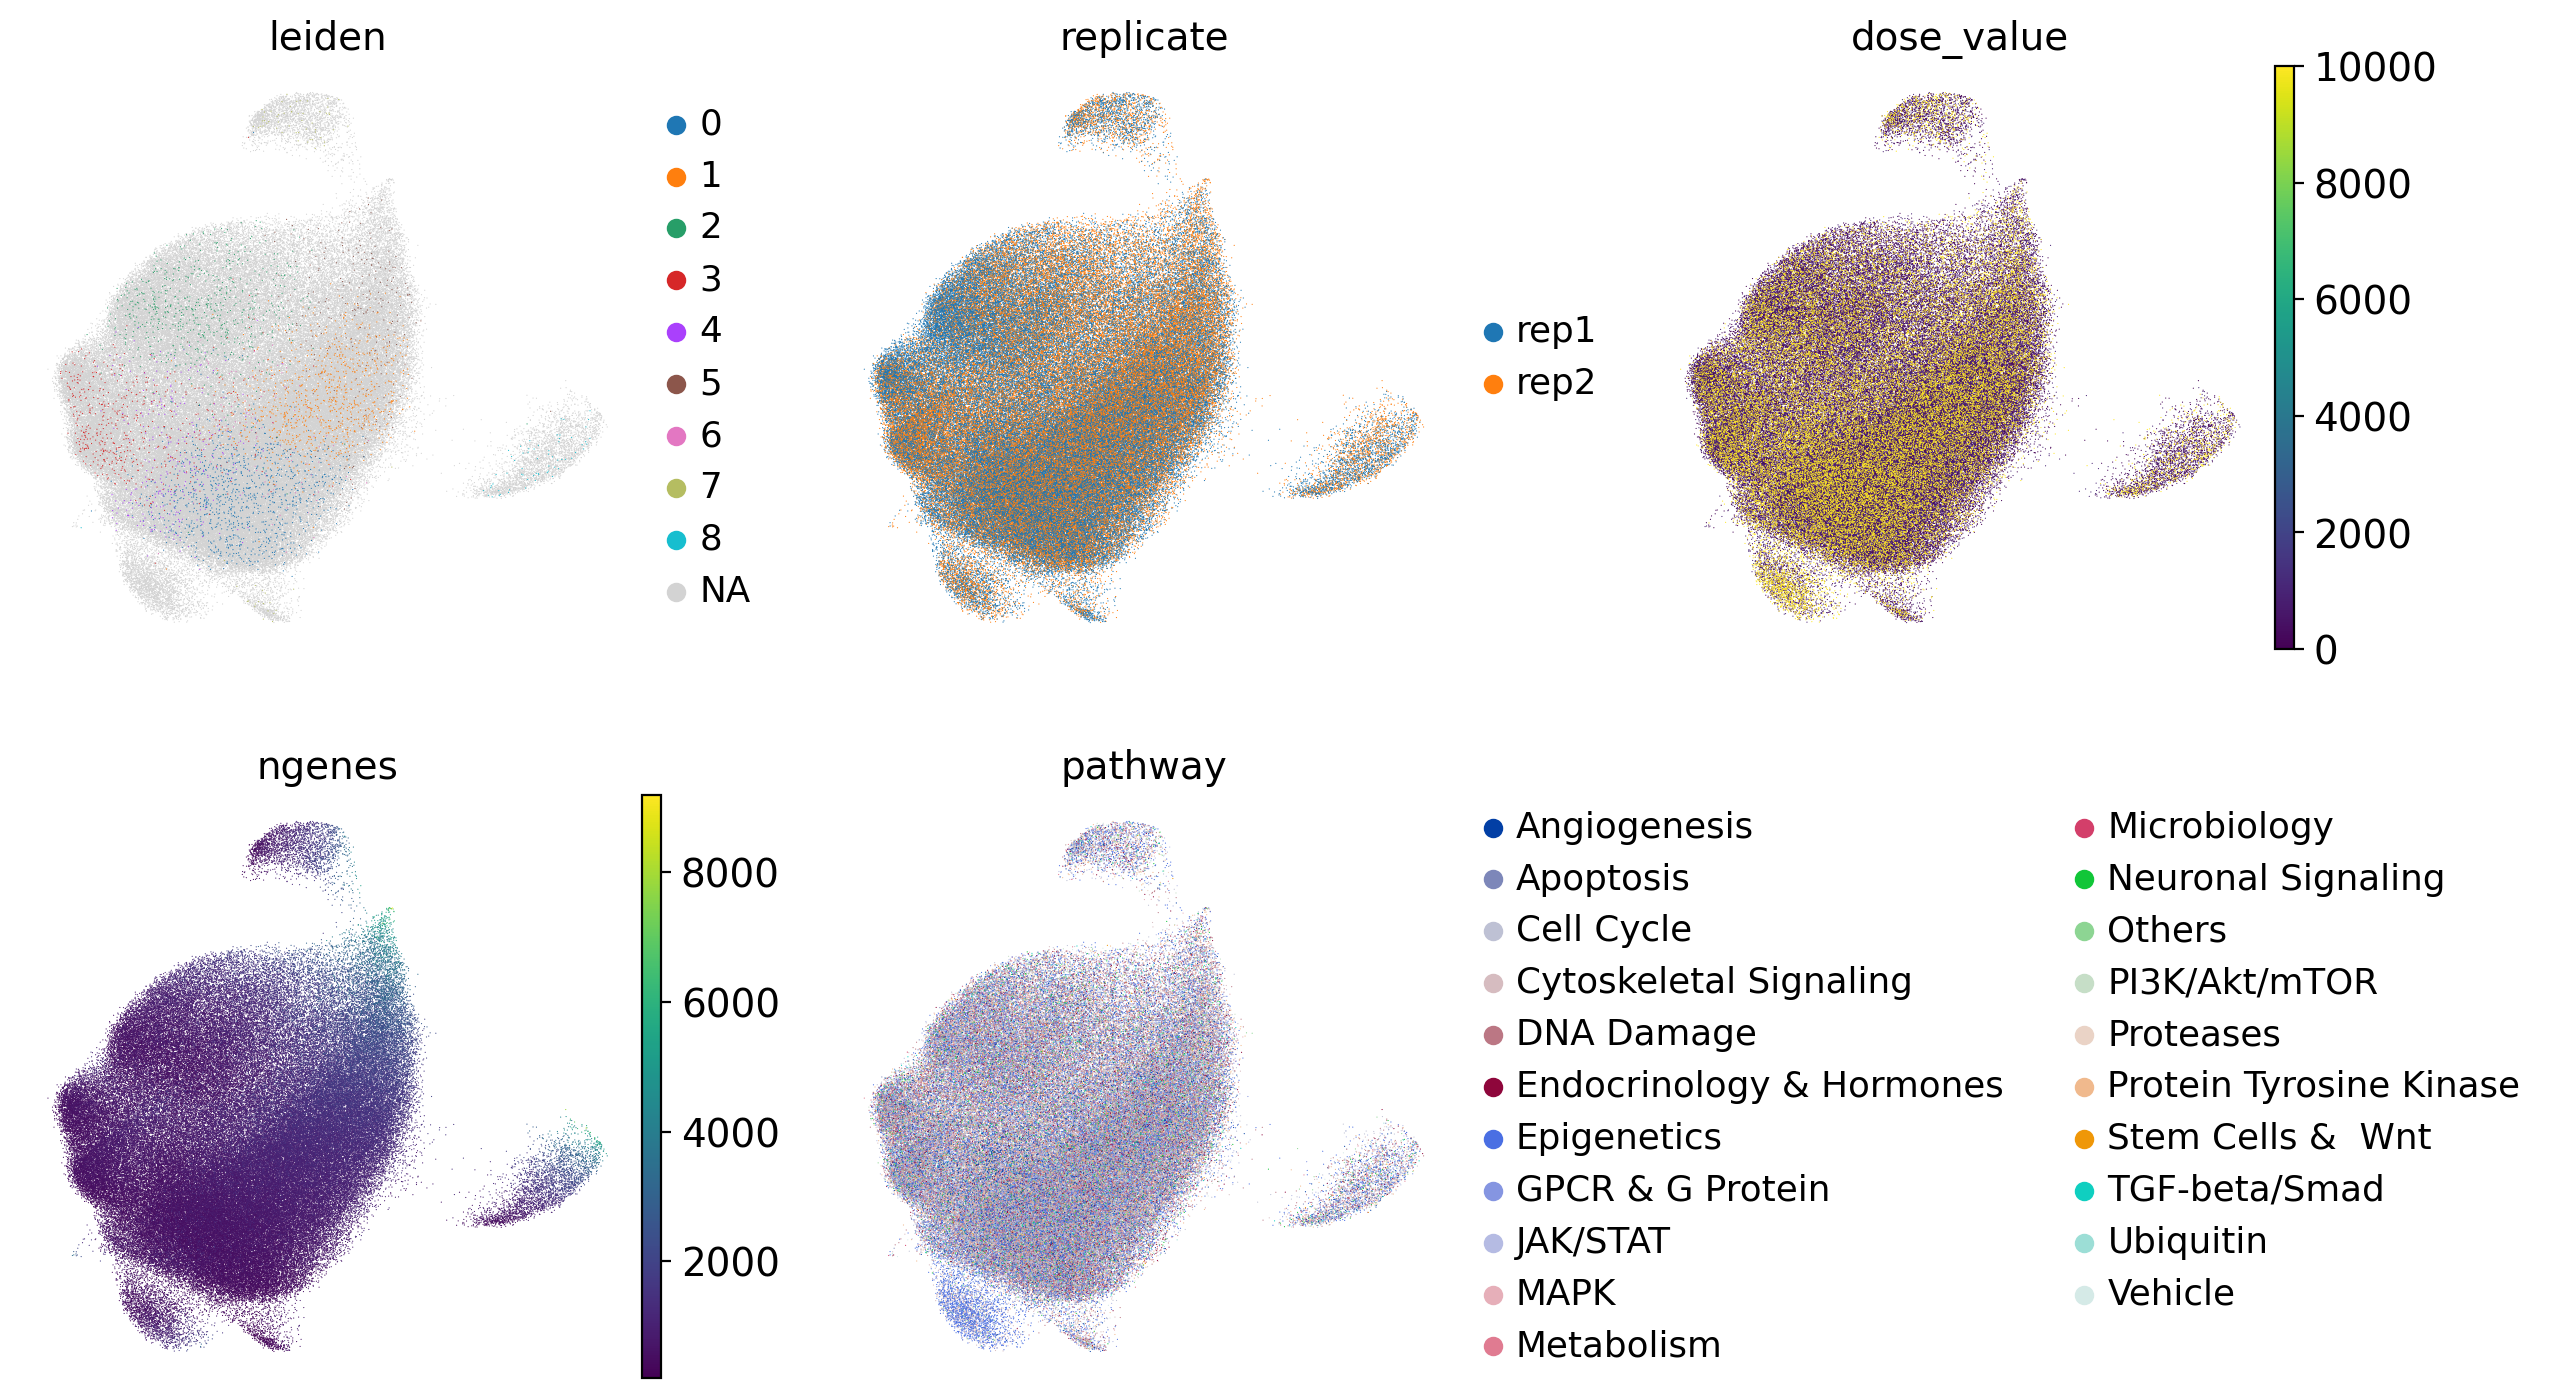

In [23]:
sc.pl.umap(adata, color=['leiden', 'replicate', 'dose_value', 'ngenes', 'pathway'], ncols=3)

To make sure the rest of the plots make sense, let's look at the distribution of treatments. The one on the far right is control.

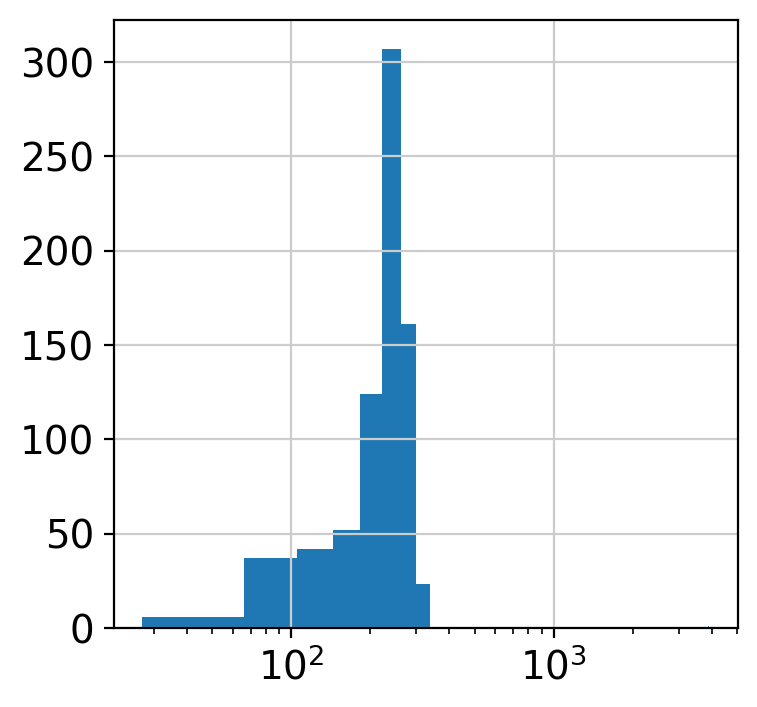

In [24]:
plt.hist(adata.obs.perturbation.value_counts().values, bins=100)
plt.xscale('log')

## run metrics for different numbers of cells

We'll still sample for 5 control populations, but we'll generate many more than that for plotting purposes. (Note that we do this randomly, or else the within-control variance is quite high). However, this time the total number of cells will be given to us by the actual total number of cells for a condition in the dataset.

Now that we have a filtered adata, we will calculate the number of differentially expressed genes per condition to use as a plotting parameter and baseline metric, in addition to getting pairwise distances dataframes for each metric. We'll use a classic volcano plot with threshold for counting the number of differentially expressed genes.

In [113]:
included_perturbations = [x for x in filtered.obs.perturbation.unique() if 'control' not in x] # set groups to save runtime
sc.tl.rank_genes_groups(adata, groupby='perturbation', groups=included_perturbations, reference='control')

In [ ]:
ndegs = {}
for p in included_perturbations:
    if p == 'control':
        continue
    
    df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(filtered, group=p), fc_thresh=.3, logpval_thresh=20, plot=False)  # extremely strict filtering
    ndegs[p] = len(up) + len(dn)

ndegs['control'] = 0

In [ ]:
experiment_condi = list(range(100, n_min_cells+10, 50)) + [n_min_cells]

for ncell in experiment_condi:
    print(ncell)
    subset = subsample(filtered, ncell)[:, adata.var['highly_variable']]
    
    for rep in ['pca', 'lognorm', 'counts']:
        inplace_check(metrics, results, DistanceResult(subset, str(ncell), rep, 'n_cells'))

100


Output()

Output()

Output()

Output()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)

## run metrics for different numbers of HVGs

How does the number of HVGs selected impact these metrics? We'll also look at whether the different flavors of HVG selection offered by `scanpy` matter here.

We'll select the HVGs from the original 10k, while including all conditions, including those that might not have enough cells.

In [22]:
experiment_condi = [10, 50, 100, 500, 1000, 2000, 5000]  # number of HVGs

feature_subsets = {}
for n in experiment_condi:
    sc.pp.highly_variable_genes(adata, n_top_genes=n, flavor='seurat')
    feature_subsets[n] = list(adata.var_names[adata.var['highly_variable']])

Calculate metrics for each perturbation.

In [ ]:
for n, features in feature_subsets.items():
    print(n)
    subset = subsample(filtered[:, features], 250)
    
#     for rep in ['pca', 'lognorm', 'counts']:
    inplace_check(metrics, results, DistanceResult(subset, str(n), 'lognorm', 'n_genes'))

10


Output()

Output()

Output()

Output()

## run metrics for different numbers of DEGs

In [19]:
included_perturbations = [x for x in filtered.obs.perturbation.unique() if 'control' not in x] # set groups to save runtime
sc.tl.rank_genes_groups(
    adata,
    groupby='perturbation',
    groups=included_perturbations,
    reference='control',
    rankby_abs=True
)

In [21]:
experiment_condi = [10, 50, 100, 150, 200]

for n in experiment_condi:
    print(n)
    subset = generate_DEG_adatas(adata, filtered, included_perturbations, n)
    
    inplace_check(metrics, results, DistanceResult(subset, str(n), 'lognorm', 'n_DEGs'))

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:01:00

Output()

100


Output()

## sparsity

To simulate differences in library size, we'll subtract 1 from random adata counts and floor at 0. Since we originally normalized with the full adata, we want to do so again (while keeping highly variable genes the same).

In [44]:
print("average number of counts per cell:", adata.obs.ncounts.mean())

average number of counts per cell: 1424.5736562151674


In [50]:
experiment_condi = list(range(10, 91, 10))

for perc in experiment_condi:
    subset = generate_sparsity(
        adata[:, adata.var['highly_variable']],
        subsample(filtered, n_min_cells).obs,
        perc
    )
    count_mean = subset.layers['counts'].mean()
    print('mean:', count_mean)
    
    inplace_check(metrics, results,
        DistanceResult(subset, "{:.3f}".format(count_mean), 'lognorm', 'count_mean'))

mean: 0.3380557


Output()


KeyboardInterrupt



## save

In [43]:
results.keys()

dict_keys(['100-pca-n_cells', '0.284-lognorm-count_mean', '0.264-lognorm-count_mean', '0.243-lognorm-count_mean', '0.222-lognorm-count_mean', '0.201-lognorm-count_mean', '0.179-lognorm-count_mean', '0.157-lognorm-count_mean', '0.134-lognorm-count_mean', '0.111-lognorm-count_mean', '10-lognorm-n_DEGs', '50-lognorm-n_DEGs', '100-lognorm-n_DEGs', '150-lognorm-n_DEGs', '200-lognorm-n_DEGs', '10-lognorm-n_genes', '50-lognorm-n_genes', '100-lognorm-n_genes', '500-lognorm-n_genes', '1000-lognorm-n_genes', '5000-lognorm-n_genes', '100-lognorm-n_cells', '100-counts-n_cells', '150-pca-n_cells', '150-lognorm-n_cells', '150-counts-n_cells', '200-pca-n_cells', '200-lognorm-n_cells', '200-counts-n_cells', '250-pca-n_cells', '250-lognorm-n_cells', '250-counts-n_cells', '270-pca-n_cells', '270-lognorm-n_cells', '270-counts-n_cells'])

In [53]:
%%time
print(results.keys())
with open(f'{dss_path}/metric_runs_sciplex.pkl', 'wb') as file:
    pickle.dump(results, file)

dict_keys(['100-pca-n_cells', '0.284-lognorm-count_mean', '0.264-lognorm-count_mean', '0.243-lognorm-count_mean', '0.222-lognorm-count_mean', '0.201-lognorm-count_mean', '0.179-lognorm-count_mean', '0.157-lognorm-count_mean', '0.134-lognorm-count_mean', '0.111-lognorm-count_mean', '10-lognorm-n_DEGs', '50-lognorm-n_DEGs', '100-lognorm-n_DEGs', '150-lognorm-n_DEGs', '200-lognorm-n_DEGs', '10-lognorm-n_genes', '50-lognorm-n_genes', '100-lognorm-n_genes', '500-lognorm-n_genes', '1000-lognorm-n_genes', '5000-lognorm-n_genes', '100-lognorm-n_cells', '100-counts-n_cells', '150-pca-n_cells', '150-lognorm-n_cells', '150-counts-n_cells', '200-pca-n_cells', '200-lognorm-n_cells', '200-counts-n_cells', '250-pca-n_cells', '250-lognorm-n_cells', '250-counts-n_cells', '270-pca-n_cells', '270-lognorm-n_cells', '270-counts-n_cells'])
CPU times: user 20.5 s, sys: 42.1 s, total: 1min 2s
Wall time: 1min 22s
